In [6]:
import torch 
torch.set_printoptions(precision=2, sci_mode=False)

In [7]:
from gofi.models import RandomMap
from gofi.graphs.loss import BijectiveLoss, RelationLoss

id = RandomMap.from_probs(torch.eye(4))
BijectiveLoss(id), BijectiveLoss(RandomMap(5))

(tensor(    0.00, grad_fn=<PowBackward0>),
 tensor(3.57, grad_fn=<PowBackward0>))

In [8]:
from gofi.graphs.graph import random_adjacency_matrix, adjacency_matrix_cayley_Sn

M = adjacency_matrix_cayley_Sn(5)
phi0 = torch.rand(120, 120, requires_grad=True)

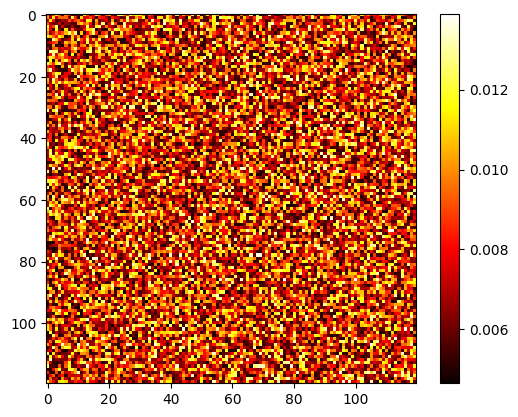

In [9]:
from gofi.graphs.opt import training
import matplotlib.pyplot as plt

initial_params= phi0.clone().detach()
initial_params.requires_grad_=True
f = RandomMap(120, initial_params=initial_params)
#f = RandomMap.from_probs(torch.eye(120))


plt.imshow(f.P().detach().numpy(), cmap="hot")
plt.colorbar()
plt.show()

#training(f, M, M, eps=0.01, max_steps=5000, adam_parameters={'lr':0.001})

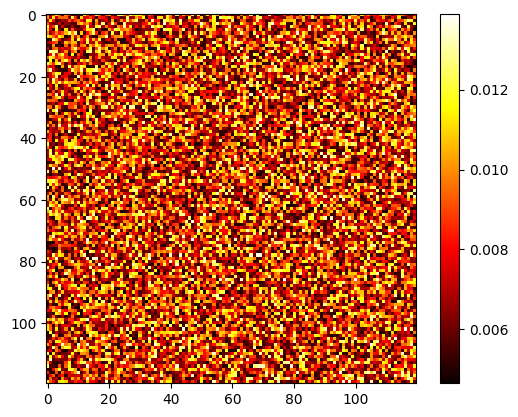

In [10]:
plt.imshow(f.P().detach().numpy(), cmap="hot")
plt.colorbar()

In [ ]:
from torchdiffeq import odeint, odeint_event
from gofi.graphs.loss import RelationLossMatrix, BijectiveLossMatrix

from gofi.graphs.opt import solve_gradient_flow

def neg_grad(t, x):
    x.requires_grad_=True
    loss = RelationLossMatrix(torch.softmax(x, dim=1), M, M)
    grad = torch.autograd.grad(loss, x)[0]#, retain_graph=True)
    return grad



#def solve_gradient_flow(phi0 : torch.Tensor, M1 : torch.Tensor, M2 : torch.Tensor):
#    return odeint(neg_grad, phi0, torch.linspace(0,30,6000))
    


phi0.requires_grad = True
phi0.retain_grad()
solutions = solve_gradient_flow(phi0, M, M)

In [12]:
phi_final = solutions[-1]
P = torch.softmax(phi_final.detach(), dim=1)

from gofi.models import closest_permutation_matrix
P_limit = closest_permutation_matrix(P)
plt.imshow(P_limit, cmap="hot")
plt.colorbar()
plt.show() 
torch.exp(-RelationLossMatrix(P_limit, M, M))

NameError: name 'solutions' is not defined

In [ ]:
import numpy as np

f = RandomMap(120, initial_params=phi_final)
d = f.mode()
table = np.array([d[i] for i in range(1, 121)])
im_size=0
for i in range(1,121):
    if  (i in table):
        im_size +=1 
        
im_size

68

/home/urh/Documents/fmf/magistrska-naloga/magisterij/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


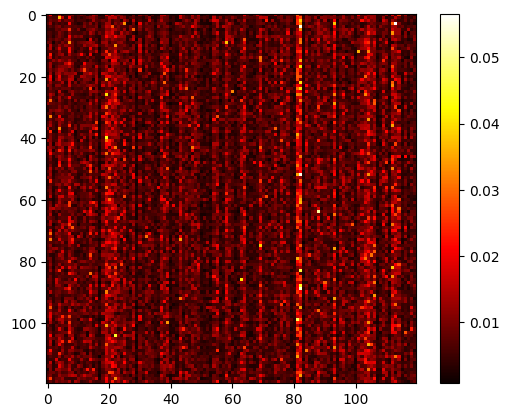

Step 1. 

In [ ]:
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from gofi.graphs.opt import training
from gofi.models import RandomMap

class MatrixGeneratorTransformerMLP(nn.Module):
    def __init__(self, n, dim=200, dim_feedforward=2048, depth=6):
        super().__init__()
        self.n = n
        self.initial = nn.Parameter(torch.rand(n, 1, dim))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=4, dim_feedforward=dim_feedforward),
            num_layers=3,
        )

        self.mlp = nn.Sequential(
            nn.Linear(dim, n)
        )

    def forward(self):

        out = self.transformer(self.initial)
        out = out.squeeze(1)
        out = self.mlp(out)
        # out = self.mlp(out)

        return torch.reshape(out, (self.n, self.n))

class MatrixGeneratorTransformer(nn.Module):
    def __init__(self, n, dim=200, depth=3):
        super().__init__()
        self.n = n
        self.initial = nn.Parameter(torch.rand(n, 1, n))

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=n, nhead=4, dim_feedforward=n * 4),
            num_layers=3,
        )

    def forward(self):

        out = self.transformer(self.initial)
        out = out.squeeze(1)
        # out = self.mlp(out)

        return torch.reshape(out, (self.n, self.n))


class MatrixGenerator(nn.Module):
    def __init__(self, n, dim1=120**2, dim2=240**2):
        super().__init__()
        self.n = n
        self.initial = nn.Parameter(torch.rand(dim1))
        self.mlp = nn.Sequential(
            nn.Linear(dim1, dim2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(dim2, self.n**2),
        )

    def forward(self):
        # Dummy input, since model doesn't depend on input
        out = self.mlp(self.initial)
        # return out.view(self.n, self.n)
        return torch.reshape(out, (self.n, self.n))


class MatrixGeneratorDouble(nn.Module):
    def __init__(self, n, hidden_dim=512, initial_dim=256):
        super().__init__()
        self.n = n
        self.initial = nn.Parameter(torch.rand(initial_dim))
        self.mlp = nn.Sequential(
            nn.Linear(initial_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim // 2, self.n**2),
        )

    def forward(self):
        # Dummy input, since model doesn't depend on input
        out = self.mlp(self.initial)
        # return out.view(self.n, self.n)
        return torch.reshape(out, (self.n, self.n))


class CoordMLP(nn.Module):
    def __init__(self, n, hidden_dim=256):
        super().__init__()
        self.n = n
        self.mlp = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self):
        # Build coordinate grid
        coords = torch.stack(
            torch.meshgrid(
                torch.linspace(0, 1, self.n),
                torch.linspace(0, 1, self.n),
                indexing="ij",
            ),
            dim=-1,
        ).reshape(
            -1, 2
        )  # shape: [n*n, 2]

        values = self.mlp(coords).view(self.n, self.n)
        return values


class ProjIntoRelu(nn.Module):
    def __init__(self, n, m, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.A = nn.Parameter(torch.rand((n, m)) * 2 - 1)
        self.B = nn.Parameter(torch.rand((m, n)) * 2 - 1)
        # ReLu, GeLu, CeLu naredijo veliko ničel in imaš obupne štartne parametre
        self.activation = nn.Softmin(dim=1)
        self.C = nn.Parameter(torch.rand((n, n)) * 2 - 1)
        self.D = nn.Parameter(torch.rand((n, n)) * 2 - 1)

    def forward(self):
        return self.activation(self.A @ self.B + self.C) @ self.D


# inner_model=ProjIntoRelu(120, 1000)
# inner_model = CoordMLP(120, hidden_dim=256)
# inner_model= MatrixGeneratorDouble(120, initial_dim=150**2)
# inner_model = MatrixGenerator(120, dim1= 125**2, dim2=256**2)
dim=10
inner_model = MatrixGeneratorTransformerMLP(120, dim=dim,dim_feedforward=10, depth=1)

f = RandomMap(120, inner_model=inner_model)

plt.imshow(f.P().detach().numpy(), cmap="hot")
plt.colorbar()
plt.show()

def transformer_schedule(warmup_steps, d_model):
    def lr_lambda(step):
        if step == 0:
            return 1e-8  # avoid division by zero
        return (d_model ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)
    return lr_lambda


def lr_lambda_simple(step):
    p = 0.1 ** (step // 1000)
    if p < 0.000001:
        p = 1.1
    return p


training(
    f,
    M,
    M,
    eps=-1,
    max_steps=20000,
    adam_parameters={"lr": 0.001},
    grad_clipping=1000,
    verbose=1,
    B=10,
    scheduler=LambdaLR,         # ReduceLROnPlateau,
    #lr_lambda=transformer_schedule(warmup_steps=4000, d_model=512)
    scheduler_parameters={'lr_lambda' :  transformer_schedule(warmup_steps=1000, d_model=dim)},   #  {"patience": 2, "factor": 0.1},
    scheduler_input=None,
)

# scheduler=LambdaLR, scheduler_parameters={'lr_lambda' : lr_lambda})

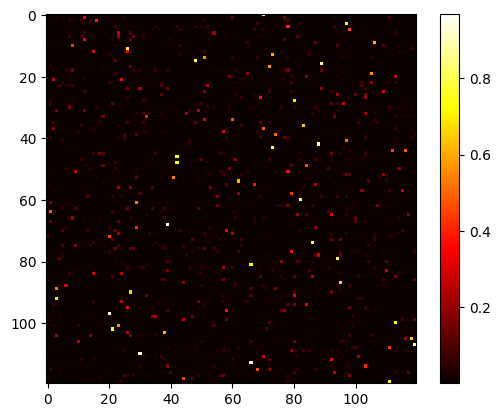

tensor(8358.38) tensor(0.)


(tensor(1051.84, grad_fn=<NegBackward0>),
 tensor(81.22, grad_fn=<PowBackward0>))

In [ ]:
from gofi.graphs.loss import RelationLossMatrix, BijectiveLossMatrix

P = f.mode_matrix()
plt.imshow(f.P().detach(), cmap="hot")
plt.colorbar()
plt.show()


print(RelationLossMatrix(P, M, M), BijectiveLossMatrix(P))
RelationLoss(f, M,M), BijectiveLoss(f)